In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 100)
pd.set_option('precision', 4)

plt.rcParams["figure.figsize"] = (15, 6)

%matplotlib inline

In [2]:
gdp= pd.read_csv("/data/gdp.csv")
gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 468 entries, 0 to 467
Data columns (total 5 columns):
iso2c        468 non-null object
Country      468 non-null object
Year         468 non-null int64
PerCapGDP    458 non-null float64
GDP          458 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 18.4+ KB


In [3]:
gdp.head()

,iso2c,Country,Year,PerCapGDP,GDP
0,CA,Canada,1960,2294.5688,4.1093e+10
1,CA,Canada,1961,2231.2938,4.0768e+10
2,CA,Canada,1962,2255.2300,4.1979e+10
3,CA,Canada,1963,2354.8391,4.4657e+10
4,CA,Canada,1964,2529.5182,4.8883e+10


In [4]:
gdp = gdp.set_index(pd.to_datetime(gdp.Year, format="%Y"))
gdp.head()

,iso2c,Country,Year,PerCapGDP,GDP
Year,,,,,
1960-01-01,CA,Canada,1960,2294.5688,4.1093e+10
1961-01-01,CA,Canada,1961,2231.2938,4.0768e+10
1962-01-01,CA,Canada,1962,2255.2300,4.1979e+10
1963-01-01,CA,Canada,1963,2354.8391,4.4657e+10
1964-01-01,CA,Canada,1964,2529.5182,4.8883e+10


In [5]:
gdp.iso2c.unique()

array(['CA', 'CN', 'DE', 'GB', 'IL', 'IN', 'JP', 'SG', 'US'], dtype=object)

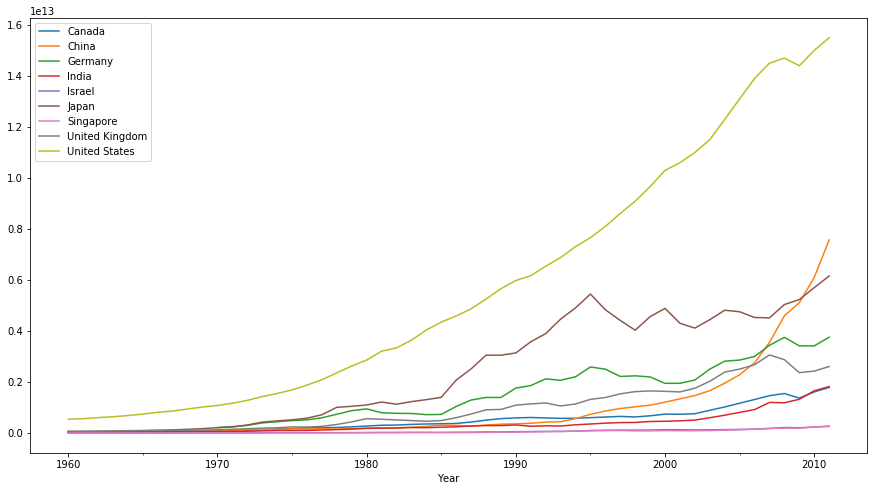

In [6]:
plt.figure(figsize = (15, 8))
gdp.groupby(["Country"]).GDP.plot(legend = True);

In [7]:
usa = gdp.query("iso2c == 'US'").PerCapGDP
usa.head()

Year
1960-01-01    3007.1234
1961-01-01    3066.5629
1962-01-01    3243.8431
1963-01-01    3374.5152
1964-01-01    3573.9412
Name: PerCapGDP, dtype: float64

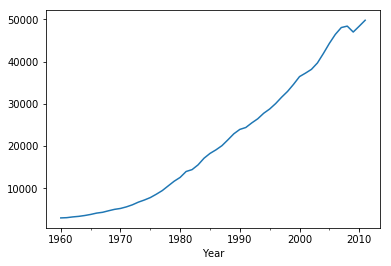

In [8]:
usa.plot()

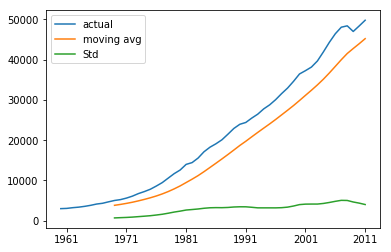

In [9]:
usa_rolling_mean = usa.rolling(window = 10, center = False).mean() 
usa_rolling_std = usa.rolling(window = 10, center = False).std() 

plt.plot(usa, label = "actual")
plt.plot(usa_rolling_mean, label = "moving avg")
plt.plot(usa_rolling_std, label = "Std")

plt.legend()


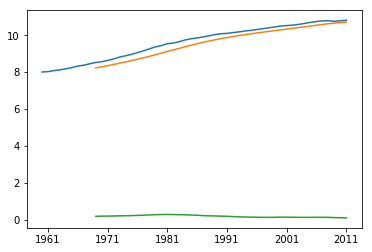

In [10]:
usa_log = np.log(usa)
usa_rolling_mean = usa_log.rolling(window = 10, center = False).mean() 
usa_rolling_std = usa_log.rolling(window = 10, center = False).std() 

plt.plot(usa_log)
plt.plot(usa_rolling_mean)
plt.plot(usa_rolling_std)


In [11]:
from statsmodels.tsa.stattools import adfuller, acf, pacf

/Users/abulbasar/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [12]:
def test_stationary(tseries):
    dftest = adfuller(tseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
            index=['Test Statistic','p-value'
                   ,'#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationary(usa)

Test Statistic                  1.9127
p-value                         0.9985
#Lags Used                      2.0000
Number of Observations Used    49.0000
Critical Value (1%)            -3.5715
Critical Value (5%)            -2.9226
Critical Value (10%)           -2.5993
dtype: float64


Because the p-value is larger than 0.05, the moving average is not constant over time and the null hypothesis of the Dickey-Fuller test cannot be rejected. This shows that the weekly time series is not stationary. Before you can apply ARIMA models for forecasting, you need to transform this time series into a stationary time series.

In [13]:
test_stationary(usa_log)

Test Statistic                 -2.9833
p-value                         0.0365
#Lags Used                      1.0000
Number of Observations Used    50.0000
Critical Value (1%)            -3.5685
Critical Value (5%)            -2.9214
Critical Value (10%)           -2.5987
dtype: float64


Because the p-value is now smaller than 0.05, we have necessary evidence to reject the null hypothesis of the Dickey-Fuller test. This shows that the time series is stationary at log scale. We can apply ARIMA model forcasting on this log scaled data.

# Remove trend and seasonality with decomposition¶

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

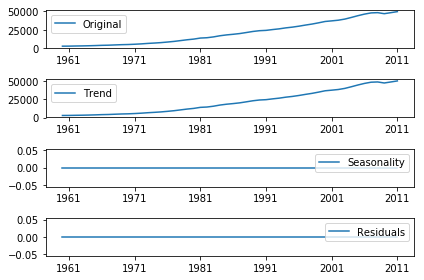

In [15]:
decomposition = seasonal_decompose(usa)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(usa, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Now that you have stationarized your time series, you could go on and model residuals (fit lines between values in the plot). However, as the patterns for the trend and seasonality information extracted from the series that are plotted after decomposition are still not consistent and cannot be scaled back to the original values, you cannot use this approach to create reliable forecasts.
In case your time series does show a strong and consistent seasonal trend, here is a good article that describes the use of the SARIMAX model in Python.


### Remove trend and seasonality with differencing

Test Statistic                 -3.7101
p-value                         0.0040
#Lags Used                      0.0000
Number of Observations Used    50.0000
Critical Value (1%)            -3.5685
Critical Value (5%)            -2.9214
Critical Value (10%)           -2.5987
dtype: float64


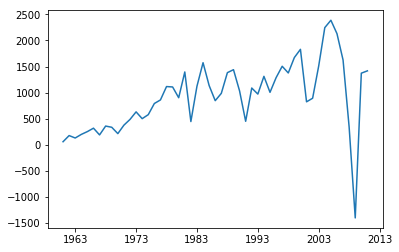

In [16]:
usa_diff = usa - usa.shift(periods=1)
usa_diff.dropna(inplace=True)
plt.plot(usa_diff)
test_stationary(usa_diff)

# Find optimal parameters and build an ARIMA (auto regressive integrated moving average) model

To apply an ARIMA model to your time series, you need to find optimal values for the following three model parameters (p,d,q):
 - The number of autoregressive (AR) terms (p): AR terms are just lags of the dependent variable, the euro rate, in this case. So, if p=2, it means that predictors of x(t) will be x(t-1) and x(t-2).
 - The number of moving average (MA) terms (q): MA terms are lagged forecast errors in the prediction equation. For instance, if q=2, the predictors for x(t) will be e(t-1) and e(t-2) where e(i) is the difference between the moving average at i-th instant and the actual value.
 - The number of differences (d): These are the number of non-seasonal differences. In your case, d=1, as you are modeling using the first order differenced time series.

There are two ways to determine the number of AR and MA terms. The first is to use the arma_order_select_ic function in Python. The second uses plots of the autocorrelation function (ACF) and partial autocorrelation function (PACF).
[This article](http://people.duke.edu/~rnau/411arim3.htm) describes in detail the purpose of the ACF and PACF plots.

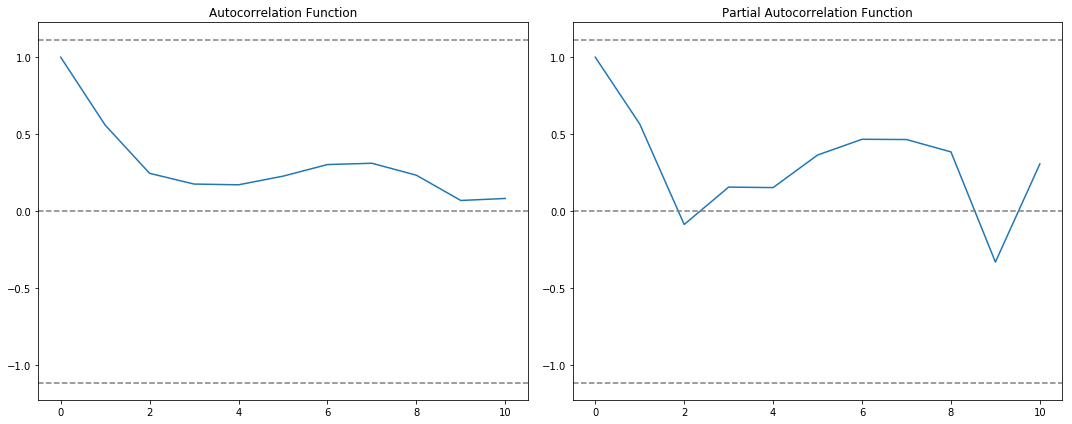

In [17]:
#ACF and PACF plots

plt.figure(figsize=(15, 6))
def plot_acf_pacf(ts):
    lag_acf = acf(ts, nlags=10)
    lag_pacf = pacf(ts, nlags=10, method='ols')

    #Plot ACF: 
    plt.subplot(121) 
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-7.96/np.sqrt(len(ts)),linestyle='--',color='gray')
    plt.axhline(y=7.96/np.sqrt(len(ts)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')

    #Plot PACF:
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-7.96/np.sqrt(len(ts)),linestyle='--',color='gray')
    plt.axhline(y=7.96/np.sqrt(len(ts)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()

    
usa_diff = usa - usa.shift(periods=1)
usa_diff.dropna(inplace=True)
plot_acf_pacf(usa_diff)

In this plot, the 'p' and 'q' values can be determined as follows:
 - p: The lag value where the PACF cuts off (drops to 0) for the first time. If you look closely, p=2.
 - q: The lag value where the ACF chart crosses the upper confidence interval for the first time. If you look closely, q=0.

This means that the optimal values for the ARIMA(p,d,q) model are (2,1,0).

If your assessment of the ACF and PACF plots differs from the values suggested by the arma_order_select_ic function, you should plug in different values for the p and q terms and use the model fit results to study the AIC values and proceed with the model with a lower AIC value

Run the next code cell to plot the ARIMA model using the values (2,1,0):

In [18]:
from statsmodels.tsa.arima_model import ARIMA

/Users/abulbasar/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/abulbasar/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/abulbasar/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


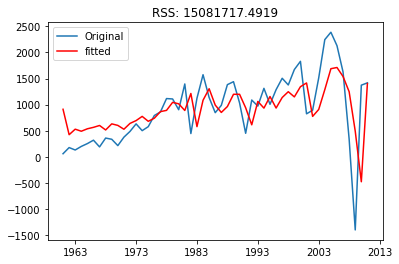

In [19]:
model = ARIMA(usa, order=(2, 1, 0))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(usa_diff, label = "Original")
plt.plot(results_ARIMA.fittedvalues, color='red', label = "fitted")
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues - usa_diff)**2))
plt.legend()

### Measure the variance between the data and the values predicted by the model

You can measure whether the results of your model fit the underlying data by using the residual sum of squares (RSS) metric. A small RSS indicates that the model fits tightly to the data.
Yet another approach to validate the ARIMA model appropriateness is by performing residual analysis.
Print the results of the ARIMA model and plot the residuals. A density plot of the residual error values indicates a normal distribution centered around zero mean. Also, the residuals do not violate the assumptions of constant location and scale with most values in the range (-1,1).

In [20]:
print(results_ARIMA.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.PerCapGDP   No. Observations:                   51
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -393.388
Method:                       css-mle   S.D. of innovations            539.434
Date:                Thu, 10 May 2018   AIC                            794.777
Time:                        15:21:26   BIC                            802.504
Sample:                    01-01-1961   HQIC                           797.730
                         - 01-01-2011                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               910.5975    159.148      5.722      0.000     598.674    1222.521
ar.L1.D.PerCapGDP     0.6227      0.139      4.481      0.000       0.350       0.895
ar.L2.D.PerCapGDP    -0.

/Users/abulbasar/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/abulbasar/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


               0
count    51.0000
mean      6.7815
std     549.1698
min   -1891.6571
25%    -259.9499
50%     -62.5588
75%     373.6328
max    1849.7060


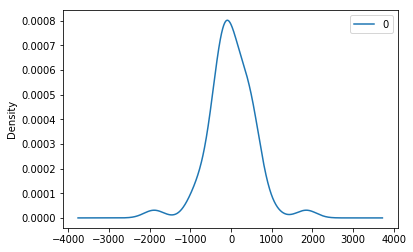

In [21]:
residuals = pd.DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde')
print(residuals.describe())

## Scale predictions

Now that the model is returning the results you want to see, you can scale the model predictions back to the original scale. For this, you will remove the first order differencing and take exponent to restore the predictions back to their original scale.
The lower the root mean square error (RMSE) and the closer it is to 0, the better are the model predictions in being closer to actual values.

In [22]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Year
1961-01-01    910.5975
1962-01-01    423.8494
1963-01-01    529.6116
1964-01-01    490.1171
1965-01-01    537.0711
dtype: float64

In [23]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA = pd.Series(usa.ix[0], index=usa.index)
predictions_ARIMA = predictions_ARIMA.add(predictions_ARIMA_diff_cumsum, fill_value=0)

/Users/abulbasar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


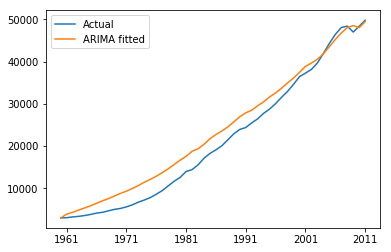

In [24]:
plt.plot(usa, label = "Actual")
plt.plot(predictions_ARIMA, label = "ARIMA fitted")
plt.legend()

## Making Predictions

In [25]:
from sklearn.metrics import mean_squared_error

In [26]:
size = int(len(usa) - 5)
train, test = usa[0:size], usa[size:len(usa)]
history = [x for x in train]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

error = mean_squared_error(test, predictions)

print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)

predictions_series = pd.Series(predictions, index = test.index)

Printing Predicted vs Expected Values...


predicted=48414.891491, expected=48061.537660
predicted=49581.111548, expected=48401.427340


/Users/abulbasar/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/abulbasar/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/abulbasar/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


predicted=48751.221681, expected=47001.555350
predicted=45550.703440, expected=48373.878820
predicted=49764.522981, expected=49790.665480


Printing Mean Squared Error of Predictions...
Test MSE: 2509769.737619


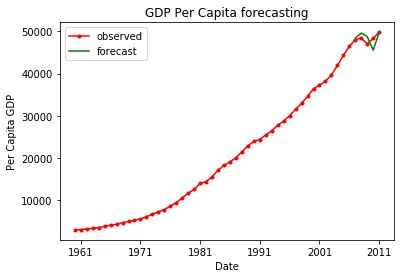

In [33]:
#rolling one-step out-of-sample
fig, ax = plt.subplots()
ax.set(title='GDP Per Capita forecasting', xlabel='Date', ylabel='Per Capita GDP')
ax.plot(usa, marker = '.', color = "red", label='observed')
ax.plot(predictions_series, color = "green", label='forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')